_Version log: Branch of V9. Trying to apply a 2DFFT insted of a 1DFFT_

In [37]:
import sys, time
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
from matplotlib import pyplot as plt, patches as mplpatches
import scipy.ndimage as spimg
from scipy import fft as spfft, linalg as spla
from PIL import Image #I prefer Pillow to imageio
from tqdm import tqdm

plt.rcParams.update({'font.size':24, 'lines.markersize': 8.0, 'lines.linewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white', 'image.interpolation': 'none'})
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $A$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||A \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

In [38]:
def open_compressed_image(file_name, file_type, compression):
    if file_type == ".png" or file_type == ".jpg":
        img = Image.open("data\\" + file_name + file_type) # read image
        img = np.array(img).sum(axis=2) # make image grayscale
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    elif file_type == ".csv":
        with open("data\\" + file_name + file_type, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        img = np.loadtxt("data\\" + file_name + file_type, delimiter=delimiter)
        array = spimg.zoom(img, compression, mode= "nearest") # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def subsample_2d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    array_flat = array.flatten()
    total_points = np.multiply(*array.shape)
    total_rows, total_columns = array.shape
    print(array.shape)

    match subsampling_method: # match case! This can replace endless if elif statements but it is not as versatile.
        case "random":
            reduced_points = round(total_points *subsampling_percentage)
            subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
        case "random_columns":
            reduced_columns = round(total_columns *subsampling_percentage)
            subsampled_columns = np.random.choice(total_columns, reduced_columns, replace= False)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
            subsampled_points = np.array(subsampled_points).flatten()           
        case "random_rows":
            reduced_rows = round(total_rows *subsampling_percentage)
            subsampled_rows = np.random.choice(total_rows, reduced_rows, replace= False)
            subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_columns":
            reduced_columns = round(total_columns *subsampling_percentage)
            subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_rows":
            reduced_rows = round(total_rows *subsampling_percentage)
            subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
            subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_grid":
            reduced_columns = round(total_columns *subsampling_percentage**0.5)
            subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
            reduced_rows = round(total_rows *subsampling_percentage**0.5)
            subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in subsampled_rows]
            subsampled_points = np.array(subsampled_points).flatten()
        case "gaussian" | "normal": # chatgpt mostly did this for me. I'm impressed that it managed to find a sensible value for the std (1/6). I might want to change the while loop though
            reduced_points = round(total_points *subsampling_percentage)
            subsampled_coords = set()
            while len(subsampled_coords) < reduced_points:
                x_coord = int(np.random.normal(total_columns/2, total_columns/3))
                y_coord = int(np.random.normal(total_rows/2, total_rows/3))

                if 0 <= x_coord < total_columns and 0 <= y_coord < total_rows:
                    subsampled_coords.add(x_coord+ y_coord*total_columns)

            subsampled_points = np.array(list(subsampled_coords)) 
        case "hadamard":
            #############IGNORES SUBSAMPLING PERCENTAGE!!!!!!################
            hadamard_size = 2**np.ceil(np.log2(np.max(array.shape))) # Make a hadamard matrix that overfills the image. The size must be a power of 2.
            hadamard_matrix = spla.hadamard(hadamard_size)
            hadamard_matrix = hadamard_matrix[:total_rows, :total_columns] #crop it to the same size as the image
            hadamard_matrix = hadamard_matrix.flatten()
            subsampled_points = np.argwhere(hadamard_matrix == 1).flatten()
        case _: #anything else
            raise ValueError("{0:} is not a valid subsampling method".format(subsampling_method))

    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal_flat = np.full(total_points, np.nan)
    signal_flat[subsampled_points] = array_flat[subsampled_points]
    signal_sparce = array_flat[subsampled_points]
    signal = np.reshape(signal_flat, array.shape)

    return signal, signal_flat, signal_sparce, subsampled_points

(75, 100)


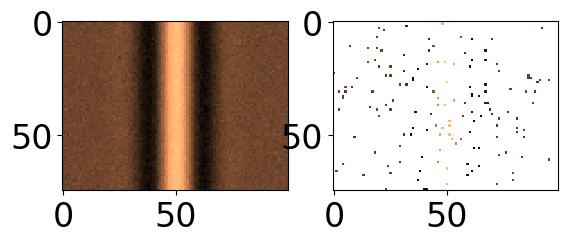

In [39]:
file_name = "2dmock2"
file_type = ".csv"
compression = 1 #fraction of the image to keep (The image is too large to process quickly)
subsample_percentage = 0.02 #fraction of the image to subsample
subsampling_method= "gaussian" #"random" "random_columns" "random_rows" "regular_grid" "regular_columns" "regular_rows" "hadamard" "gaussian"

# original image
target, img = open_compressed_image(file_name, file_type, compression)
target = np.array(target, dtype= np.float32)
target -= np.mean(target, dtype= np.float32)
total_points = np.multiply(*target.shape)

signal, signal_flat, signal_sparce, random_points_1d = subsample_2d(target, subsampling_method= subsampling_method, subsampling_percentage= subsample_percentage)
random_points_2d = np.argwhere(~np.isnan(signal))

fig, axs = plt.subplots(1,2)

axs[0].imshow(target, interpolation= "nearest")
axs[1].imshow(signal, interpolation= "nearest")

plt.show()

In [46]:
def compressed_sensing(samples, regularization_coeffient = 1e-6, silent= True):
    start_time = time.time()

    locations = np.flatnonzero(~np.isnan(samples)) # Where are the known samples located?
    known_samples = np.ravel(samples)[locations] # What are the known samples?
    reduced_points = len(locations) # How many known samples are there?
    total_points = samples.size # How many pixels do we want to reconstruct?
    idx = np.arange(reduced_points)

    dirac_deltas = np.zeros([reduced_points, total_points])
    dirac_deltas[idx, locations] = 1.
    dirac_deltas = np.reshape(dirac_deltas, (reduced_points, samples.shape[0], samples.shape[1]))
    transformation_matrix = spfft.dctn(dirac_deltas, axes= (1,2), norm= "forward", type= 1) #The idea is that do the FT of each samples' dirac delta function to give us the frequency assosciated with that sample. Not convinced that it works the way I think it does. Does work though.
    transformation_matrix = transformation_matrix.reshape(reduced_points, total_points) # 4D matrix squished into 2D. In the first dimention (rows) we have the samples [x1y1,x2y1,x3y1...x1y2...x1y3...] and in the second dimention (columns) we have the frequencies [fx1fy1,fx2fy1,fx3fy1...fx1fy2...fx1fy3...]

    transformation_matrix_time = time.time()
    if not silent: print("It took {0:.3f}s to calculate the transformation matrix".format(transformation_matrix_time -start_time))

    lasso = Lasso(alpha=regularization_coeffient, fit_intercept= False)
    lasso.fit(transformation_matrix, known_samples)
    lasso_time = time.time()
    if not silent: print("It took {0:.3f}s to complete the lasso model".format(lasso_time -transformation_matrix_time))

    result_DCT_flat = lasso.coef_

    result_DCT = result_DCT_flat.reshape(samples.shape)
    result = spfft.idctn(result_DCT, norm= "backward", type= 1)
    return result, result_DCT

result, result_dct = compressed_sensing(signal, regularization_coeffient= 1e-6, silent= False)

It took 0.070s to calculate the transformation matrix
It took 0.060s to complete the lasso model


In [47]:
#result = np.load("data\\result.npy")
#result_dct = np.load("data\\result_dct.npy")
#target = np.load("data\\target.npy")
#target_dct = np.load("data\\target_dct.npy")
#signal = np.load("data\\signal.npy")

C:\Users\syf83691\AppData\Local\Temp\ipykernel_8616\4227231660.py:11: RuntimeWarning: Mean of empty slice
  axs[1][1].plot(np.nanmean(signal, axis= 0))


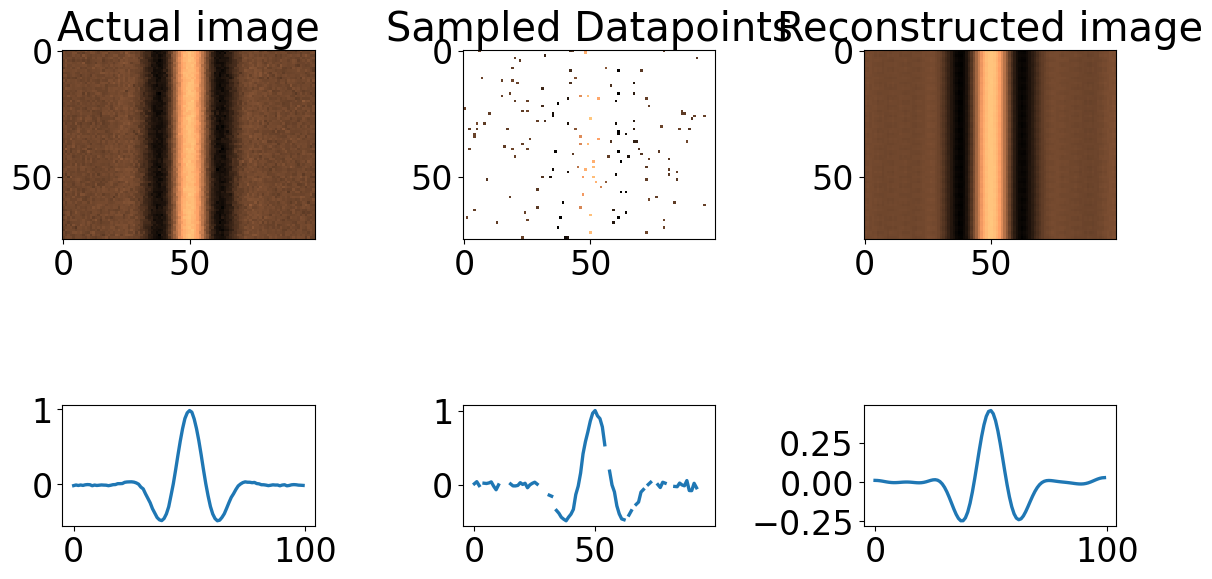

In [48]:
fig, axs = plt.subplots(2,3, figsize= (12,8), height_ratios= [1, 0.2])

axs[0][0].imshow(target, interpolation = "nearest")
axs[0][0].set_title("Actual image")
axs[0][1].imshow(signal, interpolation = "nearest")
axs[0][1].set_title("Sampled Datapoints")
axs[0][2].imshow(result, interpolation = "nearest")
axs[0][2].set_title("Reconstructed image")

axs[1][0].plot(np.nanmean(target, axis= 0))
axs[1][1].plot(np.nanmean(signal, axis= 0))
axs[1][2].plot(np.nanmean(result, axis= 0))

plt.tight_layout()
plt.show()

In [58]:
lossy_threshold = 0.995


target_dct = spfft.dctn(target, norm= "backward", type= 1)

is_significant = 1e-10 < np.abs(result_dct)
result_dct[~is_significant] = np.nan

lossy_dct = np.zeros_like(target_dct)
is_significant = np.percentile(np.abs(target_dct), (lossy_threshold)*100) < np.abs(target_dct)
lossy_dct[is_significant] = target_dct[is_significant]
lossy = spfft.idctn(lossy_dct, norm= "backward", type= 1)
lossy_dct[~is_significant] = np.nan

p = 0.3

In [59]:
np.nanmax(result_dct)

1818.9702093190936

In [60]:
np.nanmax(target_dct)

3707.246

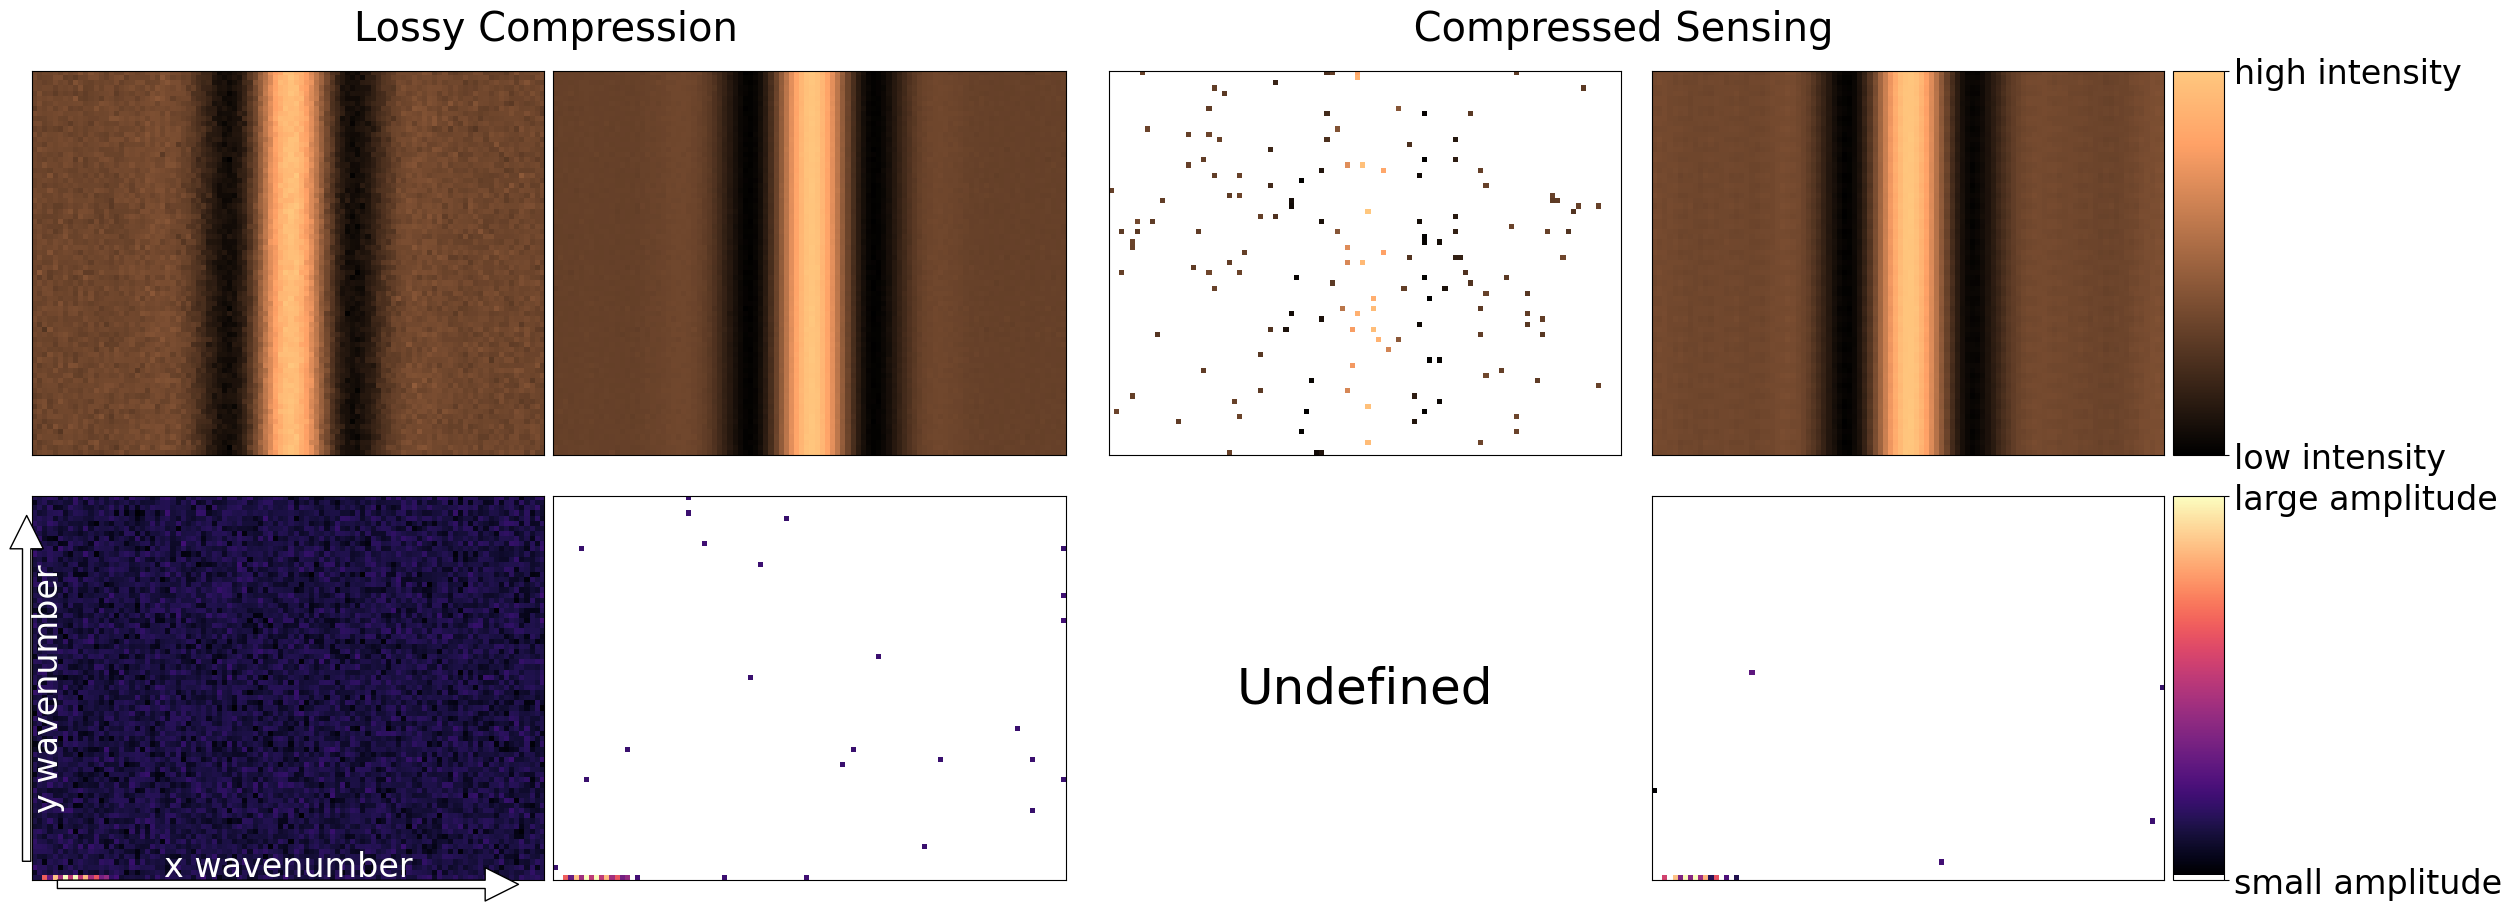

In [61]:
plt.rcParams.update({"font.size": 24, "image.cmap": "copper"})

fig = plt.figure(layout= "constrained", figsize= (25, 9), facecolor='none')
fig.suptitle("Lossy Compression                                                     Compressed Sensing", x= 0.435)

axs = fig.subplots(2, 6, gridspec_kw= {"wspace":0, "hspace":0, "width_ratios": (1,1,0.05,1,1,0.1)})
axs = np.ravel(axs)

im_idct = axs[0].imshow(target, interpolation= "none")
axs[0].set(xticks= [], yticks= [], facecolor='white')
im_dct = axs[6].imshow(np.abs(target_dct)**p, cmap= "magma", origin= "lower")
axs[6].set(xticks= [], yticks= [], facecolor='white')
axs[6].annotate("", xy=(1, -0.01), xytext=(0, -0.01), xycoords = 'axes fraction', arrowprops=dict(facecolor='white', shrink=0.05, width= 6, headwidth= 24, headlength= 24))
axs[6].annotate("x wavenumber", xy=(0.5, 0.01), xycoords = 'axes fraction', color= "white", ha= "center")
axs[6].annotate("", xy=(-0.01, 1), xytext=(-0.01, 0), xycoords = 'axes fraction', arrowprops=dict(facecolor='white', shrink=0.05, width= 6, headwidth= 24, headlength= 24))
axs[6].annotate("y wavenumber", xy=(0, 0.5), xycoords = 'axes fraction', color= "white", va= "center", rotation= 90)

axs[1].imshow(lossy, interpolation= "none")
axs[1].set(xticks= [], yticks= [], facecolor='white')
axs[7].imshow(np.abs(lossy_dct)**p, cmap= "magma", origin= "lower", vmin= im_dct.get_clim()[0], vmax= im_dct.get_clim()[1])
axs[7].set(xticks= [], yticks= [], facecolor='white')

axs[2].axis("off")
axs[8].axis("off")

axs[3].imshow(signal, interpolation= "none")
axs[3].set(xticks= [], yticks= [], facecolor='white')
axs[9].axis("off")
axs[9].text(0.5, 0.5, "Undefined", horizontalalignment= "center", verticalalignment= "center", fontsize= 36)
axs[9].set(xticks= [], yticks= [], facecolor='white')

axs[4].imshow(result, interpolation= "none")
axs[4].set(xticks= [], yticks= [], facecolor='white')
axs[10].imshow(np.abs(result_dct)**p, cmap= "magma", origin= "lower")
axs[10].set(xticks= [], yticks= [], facecolor='white')
axs[10].annotate("", xy=(1, -0.01), xytext=(0, -0.01), xycoords = 'axes fraction', arrowprops=dict(facecolor='none', edgecolor= 'none', width= 6, headwidth= 24, headlength= 24))
axs[10].annotate("", xy=(-0.01, 1), xytext=(-0.01, 0), xycoords = 'axes fraction', arrowprops=dict(facecolor='none', edgecolor= 'none', width= 6, headwidth= 24, headlength= 24))

cbar_idct = fig.colorbar(im_idct, ax= axs[0], cax= axs[5])
cbar_idct.set_ticks(ticks= [np.min(target), np.max(target)], labels=["low intensity", "high intensity"])
cbar_dct = fig.colorbar(im_dct, ax= axs[6], cax= axs[11])
cbar_dct.set_ticks(ticks= [0, np.max(np.abs(target_dct)**p)], labels=["small amplitude", "large amplitude"])

fig.savefig("graphs\\alfie_lc_vs_cs3")
plt.show()

In [45]:
#np.save("data\\result", result)
#np.save("data\\result_dct", result_dct)
#np.save("data\\target", target)
#np.save("data\\target_dct", target_dct)
#np.save("data\\signal", signal)